In [2]:
import numpy as np
#from LogGabor import LogGaborFit
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch
from SDPC_PCB.DataTools import DataBase
import pickle
from torchvision.datasets import STL10
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
import torch.nn.functional as f
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader

In [3]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt

def reconstruction(Net,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

In [4]:
path_saving = 'Savings/Fig'

## Figure 2 - STL10 database

In [5]:
data_path = '../DataSet/STL10'

transform = Compose([ToTensor(),
                    to_cuda(),
                    whitening((96,96),f_0=0.5),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    #])
                    mask((96,96))])

dataset = STL10(data_path, transform=transform, download=False, split='train')

DataBase = DataLoader(dataset, batch_size=20, shuffle=False, drop_last=True)

In [6]:
#model_name = 'STL_20tr_l=[0.4,1.6]_b=1_learnv_v=6_[64,128]_sig=30_sz=8_stride=2.pkl'
model_name = 'STL_[0.4,1.6]_b=1.pkl'

model_type = model_name[0:8]
name = model_name
print(name)
where = 'Savings/STL/'
path = where + name
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
Pursuit = out['Pursuit']
Loss = out['Loss']

STL_[0.4,1.6]_b=1.pkl


### Fig2 a,c,e

In [7]:
nb_image = 20*20
all_batch = torch.zeros(nb_image,3,96,96).cuda()
save_gamma_0 = torch.zeros(nb_image,64,45,45).cuda()
save_gamma_1 = torch.zeros(nb_image,128,38,38).cuda()
k = 0
for idx_batch, data in enumerate(DataBase):
    batch = data[0].cuda()
    all_batch[k:k+batch.size(0),:,:,:] = batch
    gamma, it, Loss_G, delta = Pursuit.coding(batch)

    save_gamma_0[k:k+batch.size(0),:,:,:] = gamma[0][:,:,:,:]
    save_gamma_1[k:k+batch.size(0),:,:,:] = gamma[1][:,:,:,:]
    k+=batch.size(0)
    if k >= nb_image:
        break

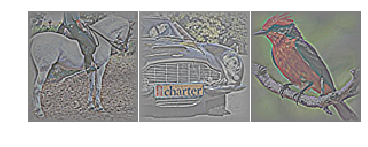

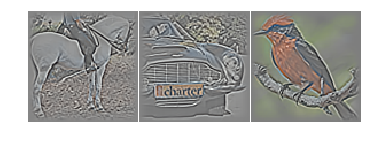

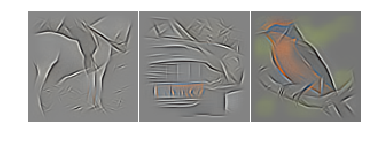

In [8]:

nb_img_to_plot = 3
selected_img = [22,23,24]
gamma_n = [save_gamma_0[selected_img,:,:,:],save_gamma_1[selected_img,:,:,:]]
reco = reconstruction(Net,gamma_n)

save_fig = False

## Display input_data
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(all_batch[selected_img,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][:,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2a.png')

    
## Display fist layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(reco[0][:,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][:,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2c.png')

## Display second layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(reco[1][:,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[1][:,:,:,:].cpu(), **grid_param), path_saving +'/Fig2/Fig2e.png')

### Fig 2 b,d

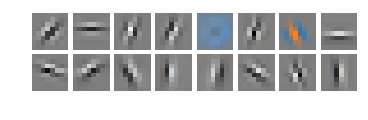

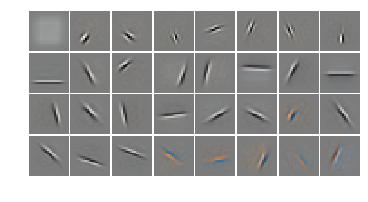

In [9]:
te = (save_gamma_1!=0).float().permute(1,0,2,3)
te = te.contiguous().view(128,-1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)

nb_dico_to_plot = 16
np.random.seed(6)
save_fig = False

dico = Net.layers[0].dico
selected_dico = np.random.choice(np.arange(dico.size()[0]), nb_dico_to_plot, replace=False)
dico = dico[selected_dico,:,:,:]

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':8, 'scale_each':False}
to_show = show(make_grid(dico.clone().cpu(), **grid_param))
to_show.show()

if save_fig :
    save_image(make_grid(dico.clone().cpu(), **grid_param), path_saving + '/Fig2/Fig2b.png')

dico = Net.layers[0].backward(Net.layers[1].dico)
dico = dico[idx_sorted]
nb_dico_to_plot = 32
subsamp = torch.arange(0,128,4)

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':8, 'scale_each':False}
to_show = show(make_grid(dico[subsamp].clone().cpu(), **grid_param))
to_show.show()

if save_fig :
    save_image(make_grid(dico[subsamp].clone().cpu(), **grid_param), path_saving + '/Fig2/Fig2d.png')
    

## Fig S1

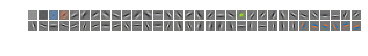

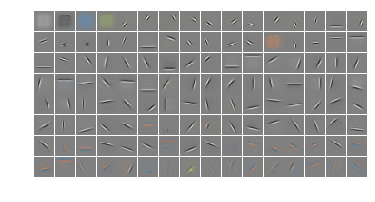

In [10]:
save_fig =False

te = (save_gamma_0!=0).float().permute(1,0,2,3)
te = te.contiguous().view(64,-1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)

dico = Net.layers[0].dico
dico = dico[idx_sorted]

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':32}
image = make_grid(dico.clone().cpu(), **grid_param)
to_show = show(image)
to_show.show()

if save_fig :
    save_image(image,path_saving + '/FigS1/FigS1a.png')
    
te = (save_gamma_1!=0).float().permute(1,0,2,3)
te = te.contiguous().view(128,-1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)


dico = Net.layers[0].backward(Net.layers[1].dico)
dico = dico[idx_sorted]

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':16}
image = make_grid(dico.clone().cpu(), **grid_param)
to_show = show(image)
to_show.show()

if save_fig :
    save_image(image, path_saving + '/FigS1/FigS1b.png')
    

## Figure 2 - CFD Database

In [11]:
from SDPC_PCB.DataTools import DataBase

In [12]:
#model_name = 'CBCF_0025_l=[0.3,1.6]_b=1_learnv_v=6_[64,128]_sig=30_sz=9.pkl'
model_name = 'CFD_[0.3,1.6]_b=1.pkl'

model_type = model_name[0:8]
name = model_name
print(name)
where = 'Savings/CFD/'
path = where + name
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
Pursuit = out['Pursuit']
Loss = out['Loss']

CFD_[0.3,1.6]_b=1.pkl


In [13]:
data_path ='../DataSet/CF_DB/'

LCN_params = {'kernel_size':11,
'sigma':0.5,
'rgb':True}

mask_params={'n': 10}# default is 10

whitening_params={'f_0':0.5,
'n':2}

Data_load_param = {'batch_size': 10,
'do_LCN': True,
'LCN_params': LCN_params,
'do_mask': True,
'mask_params': mask_params,
'do_whitening': True,
'whitening_params': whitening_params,
'do_z_score': True,
'return_idx': False}

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124), reshaped_size=(120,171),**Data_load_param, shuffle=False)

In [14]:
nb_image = 10*40
save_gamma_0 = torch.zeros(nb_image,64,38,55).cuda()
save_gamma_1 = torch.zeros(nb_image,128,30,47).cuda()
k = 0
for idx_batch, data in enumerate(Facedata.data):
    batch = data[0].cuda()
    gamma, it, Loss_G, delta = Pursuit.coding(batch)
    save_gamma_0[k:k+batch.size(0),:,:,:] = gamma[0][:,:,:,:]
    save_gamma_1[k:k+batch.size(0),:,:,:] = gamma[1][:,:,:,:]
    k+=batch.size(0)
    if k >= nb_image:
        break
    

### Fig2 f,h,j

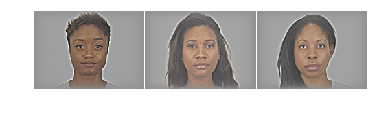

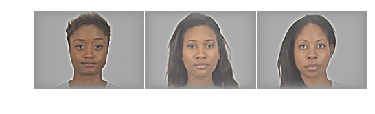

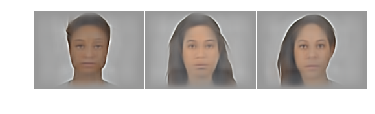

In [15]:

nb_img_to_plot = 3
reco = reconstruction(Net,gamma)
selected_img = np.arange(nb_img_to_plot)
save_fig = False

## Display input_data
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':6}
img2 = show(make_grid(batch[selected_img,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][selected_img,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2f.png')

    
## Display fist layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':6}
img2 = show(make_grid(reco[0][selected_img,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][selected_img,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2h.png')

## Display second layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':5}
img2 = show(make_grid(reco[1][selected_img,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[1][selected_img,:,:,:].cpu(), **grid_param), path_saving +'/Fig2/Fig2j.png')

### Fig2 g,i

In [16]:
te = (save_gamma_1!=0).float().permute(1,0,2,3)
te = te.contiguous().view(128,-1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)

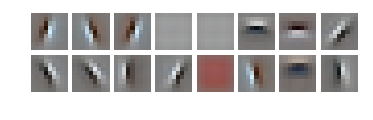

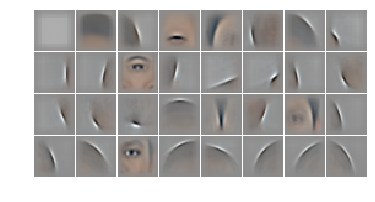

In [17]:
nb_dico_to_plot = 16
np.random.seed(4)
save_fig = False

dico = Net.layers[0].dico
selected_dico = np.random.choice(np.arange(dico.size()[0]), nb_dico_to_plot, replace=False)
dico = dico[selected_dico,:,:,:]

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':8}
to_show = show(make_grid(dico.clone().cpu(), **grid_param))
to_show.show()
if save_fig :
    save_image(make_grid(dico.clone().cpu(), **grid_param), path_saving + '/Fig2/Fig2g.png')

dico = Net.layers[0].backward(Net.layers[1].dico)
dico = dico[idx_sorted]
nb_dico_to_plot = 32
subsamp = torch.arange(0,128,4)

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':8}
to_show = show(make_grid(dico[subsamp].clone().cpu(), **grid_param))
to_show.show()

if save_fig :
    save_image(make_grid(dico[subsamp].clone().cpu(), **grid_param), path_saving + '/Fig2/Fig2i.png')

## FigS2

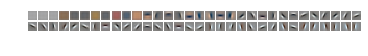

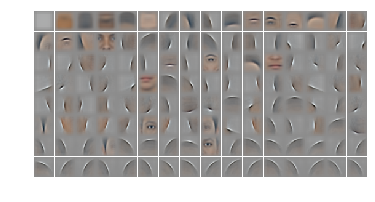

In [18]:
save_fig = False

te = (save_gamma_0!=0).float().permute(1,0,2,3)
te = te.contiguous().view(64,-1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)
dico = Net.layers[0].dico
dico = dico[idx_sorted]

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':32}
image = make_grid(dico.clone().cpu(), **grid_param)
to_show = show(image)
to_show.show()

if save_fig :
    save_image(image, path_saving + '/FigS2/FigS2a.png')
    
te = (save_gamma_1!=0).float().permute(1,0,2,3)
te = te.contiguous().view(128,-1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)


dico = Net.layers[0].backward(Net.layers[1].dico)
dico = dico[idx_sorted]

grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':16}
image = make_grid(dico.clone().cpu(), **grid_param)
to_show = show(image)
to_show.show()

if save_fig :
    save_image(image, path_saving + '/FigS2/FigS2b.png')
    